# Simulation of a single-product perishable inventory problem (Setting 2)

In [ ]:
### This cell should be run once
%load_ext autoreload
%autoreload 2
%cd ..

In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.cup import CUP_algorithm
from algorithms.maxcosd_box import MaxCOSD_Box_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the environment
* Horizon: $T=1969$
* Number of runs: $N=10$
* Number of products: $n=1$
* Demand distribution: $d_{t,1}\sim\text{Poisson}(1)$
* Cost parameters: $h=1$, $p=200$
* Feasible set: $\mathcal{Y}=[0,10]$
* Constants: $G = \max\{h,p\}$

In [3]:
nb_samples = 10
nb_products = 1
horizon = 1969
holding_costs = np.ones(nb_products)
penalty_costs = 200*np.ones(nb_products)

np.random.seed(1)
envs = []
for sample_id in range(nb_samples) :
    demands = np.zeros((horizon+1,nb_products))
    demands[1:,:] = scipy.stats.poisson(1).rvs(size=(horizon, nb_products))
    envs.append(Environment_Perishable_Newsvendor(2, demands,holding_costs,penalty_costs))

In [4]:
y_min = 0*np.ones(nb_products)
y_max = 10*np.ones(nb_products)
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

### Defining the algorithms
* 55 instances of CUP with $\gamma$ ranging from $10^{-5}$ to $10^1$
* 55 instances of MaxCOSD with $\gamma$ ranging from $10^{-5}$ to $10^1$

In [5]:
initial_decision = np.zeros(nb_products)
list_gamma = [10**exponent for exponent in np.linspace(-5,1,9*6+1)]

algs = [CUP_algorithm(initial_decision, y_min,y_max, gamma, G) for gamma in list_gamma]
algs += [MaxCOSD_Box_algorithm(initial_decision,y_min,y_max,gamma) for gamma in list_gamma]
    
nb_algs = len(algs)

### Running the simulation

In [6]:
horizons = np.unique(np.logspace(np.log10(1),np.log10(horizon),100).astype(int))

sim = Simulator(envs, nb_products, nb_samples, horizons, algs,
    lambda optimum : ((optimum>=y_min).all() and (optimum<=y_max).all()), holding_costs,penalty_costs)
cum_losses = sim.run()

100%|██████████| 110/110 [00:13<00:00,  7.86it/s]


### Figures
#### $R_T$ as a function of $\gamma$ in semilogx scale

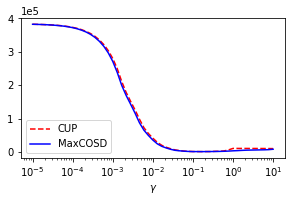

In [19]:
cup_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
maxcosd_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(4.16,2.91))
plt.semilogx(list_gamma,cup_mean_regret, color="red", label="CUP",linestyle="--")
plt.semilogx(list_gamma,maxcosd_mean_regret, color="blue", label="MaxCOSD")

plt.xlabel(r"$\gamma$")
plt.legend(loc="lower left")
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
plt.savefig("images/setting_2_gamma_logx.png", dpi=300)
plt.show()

#### $R_T$ as a function of $\gamma$ in loglog scale

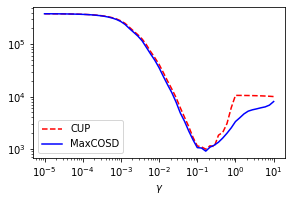

In [18]:
cup_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
maxcosd_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(4.16,2.91))
plt.loglog(list_gamma,cup_mean_regret, color="red", label="CUP",linestyle="--")
plt.loglog(list_gamma,maxcosd_mean_regret, color="blue", label="MaxCOSD")

plt.xlabel(r"$\gamma$")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("images/setting_2_gamma_loglog.png", dpi=300)
plt.show()

#### $R_T/T$ as a function of $T$ in loglog scale

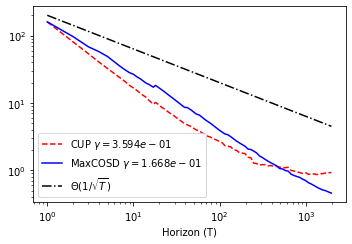

In [17]:
cup_gamma_index_opt = np.argmin(cum_losses[0,1:len(list_gamma)+1,-1])+1
maxcosd_gamma_index_opt = np.argmin(cum_losses[0,1*len(list_gamma)+1:2*len(list_gamma)+1,-1])+1*len(list_gamma)+1
colors = {cup_gamma_index_opt:"red", maxcosd_gamma_index_opt:"blue"}
linestyles = {cup_gamma_index_opt:"--", maxcosd_gamma_index_opt:"-"}

plt.figure(figsize=(5,3.5))

for i in [cup_gamma_index_opt, maxcosd_gamma_index_opt] :
    y = np.mean(cum_losses[:,i,:]-cum_losses[:,0,:],axis=0)
    plt.loglog(horizons, y/horizons,label=algs[i-1], color=colors[i], linestyle=linestyles[i])
    
plt.loglog(horizons,2*10**2/np.sqrt(horizons),"-.",color="k",label=r"$\Theta(1/\sqrt{T})$")

plt.xlabel("Horizon (T)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("images/setting_2_avgregret.png", dpi=300)
plt.show()